# **Assignment \#3**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Marcelo Reis, 2022s1



In [ ]:
# TODO: RA & Name 
print('RA1: 220102 | ' + 'André Luiz do Canto Portela')
print('RA2: 183298 | ' + 'Marcelo Aparecido Moreira')

RA1: 220102 | André Luiz do Canto Portela
RA2: 183298 | Marcelo Aparecido Moreira


## Objective 

Explore **classification techniques** (logistic regression & neural networks) and come up with the best possible model to the problem, avoiding overfitting. In particular, build an object recognition system to accurately classify images using the [PathMNIST dataset](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002730).

## Dataset

PathMNIST is a dataset of [MedMNIST's article](https://medmnist.com/v1) images, consisting of a training set of 89,996 examples, validation set of 10,004 examples and a test set of 7,180 examples. Each colon pathology example is a 28x28 RGB image, associated with a label from 9 classes.

Each example is assigned to one of the following labels:

**Label 	Description**
- ADI 	adipose tissue
- BACK 	background
- DEB 	debris
- LYM 	lymphocytes
- MUC 	mucus
- MUS 	smooth muscle
- NORM 	normal colon mucosa
- STR 	cancer-associated stroma
- TUM 	colorectal adenocarcinoma epithelium.






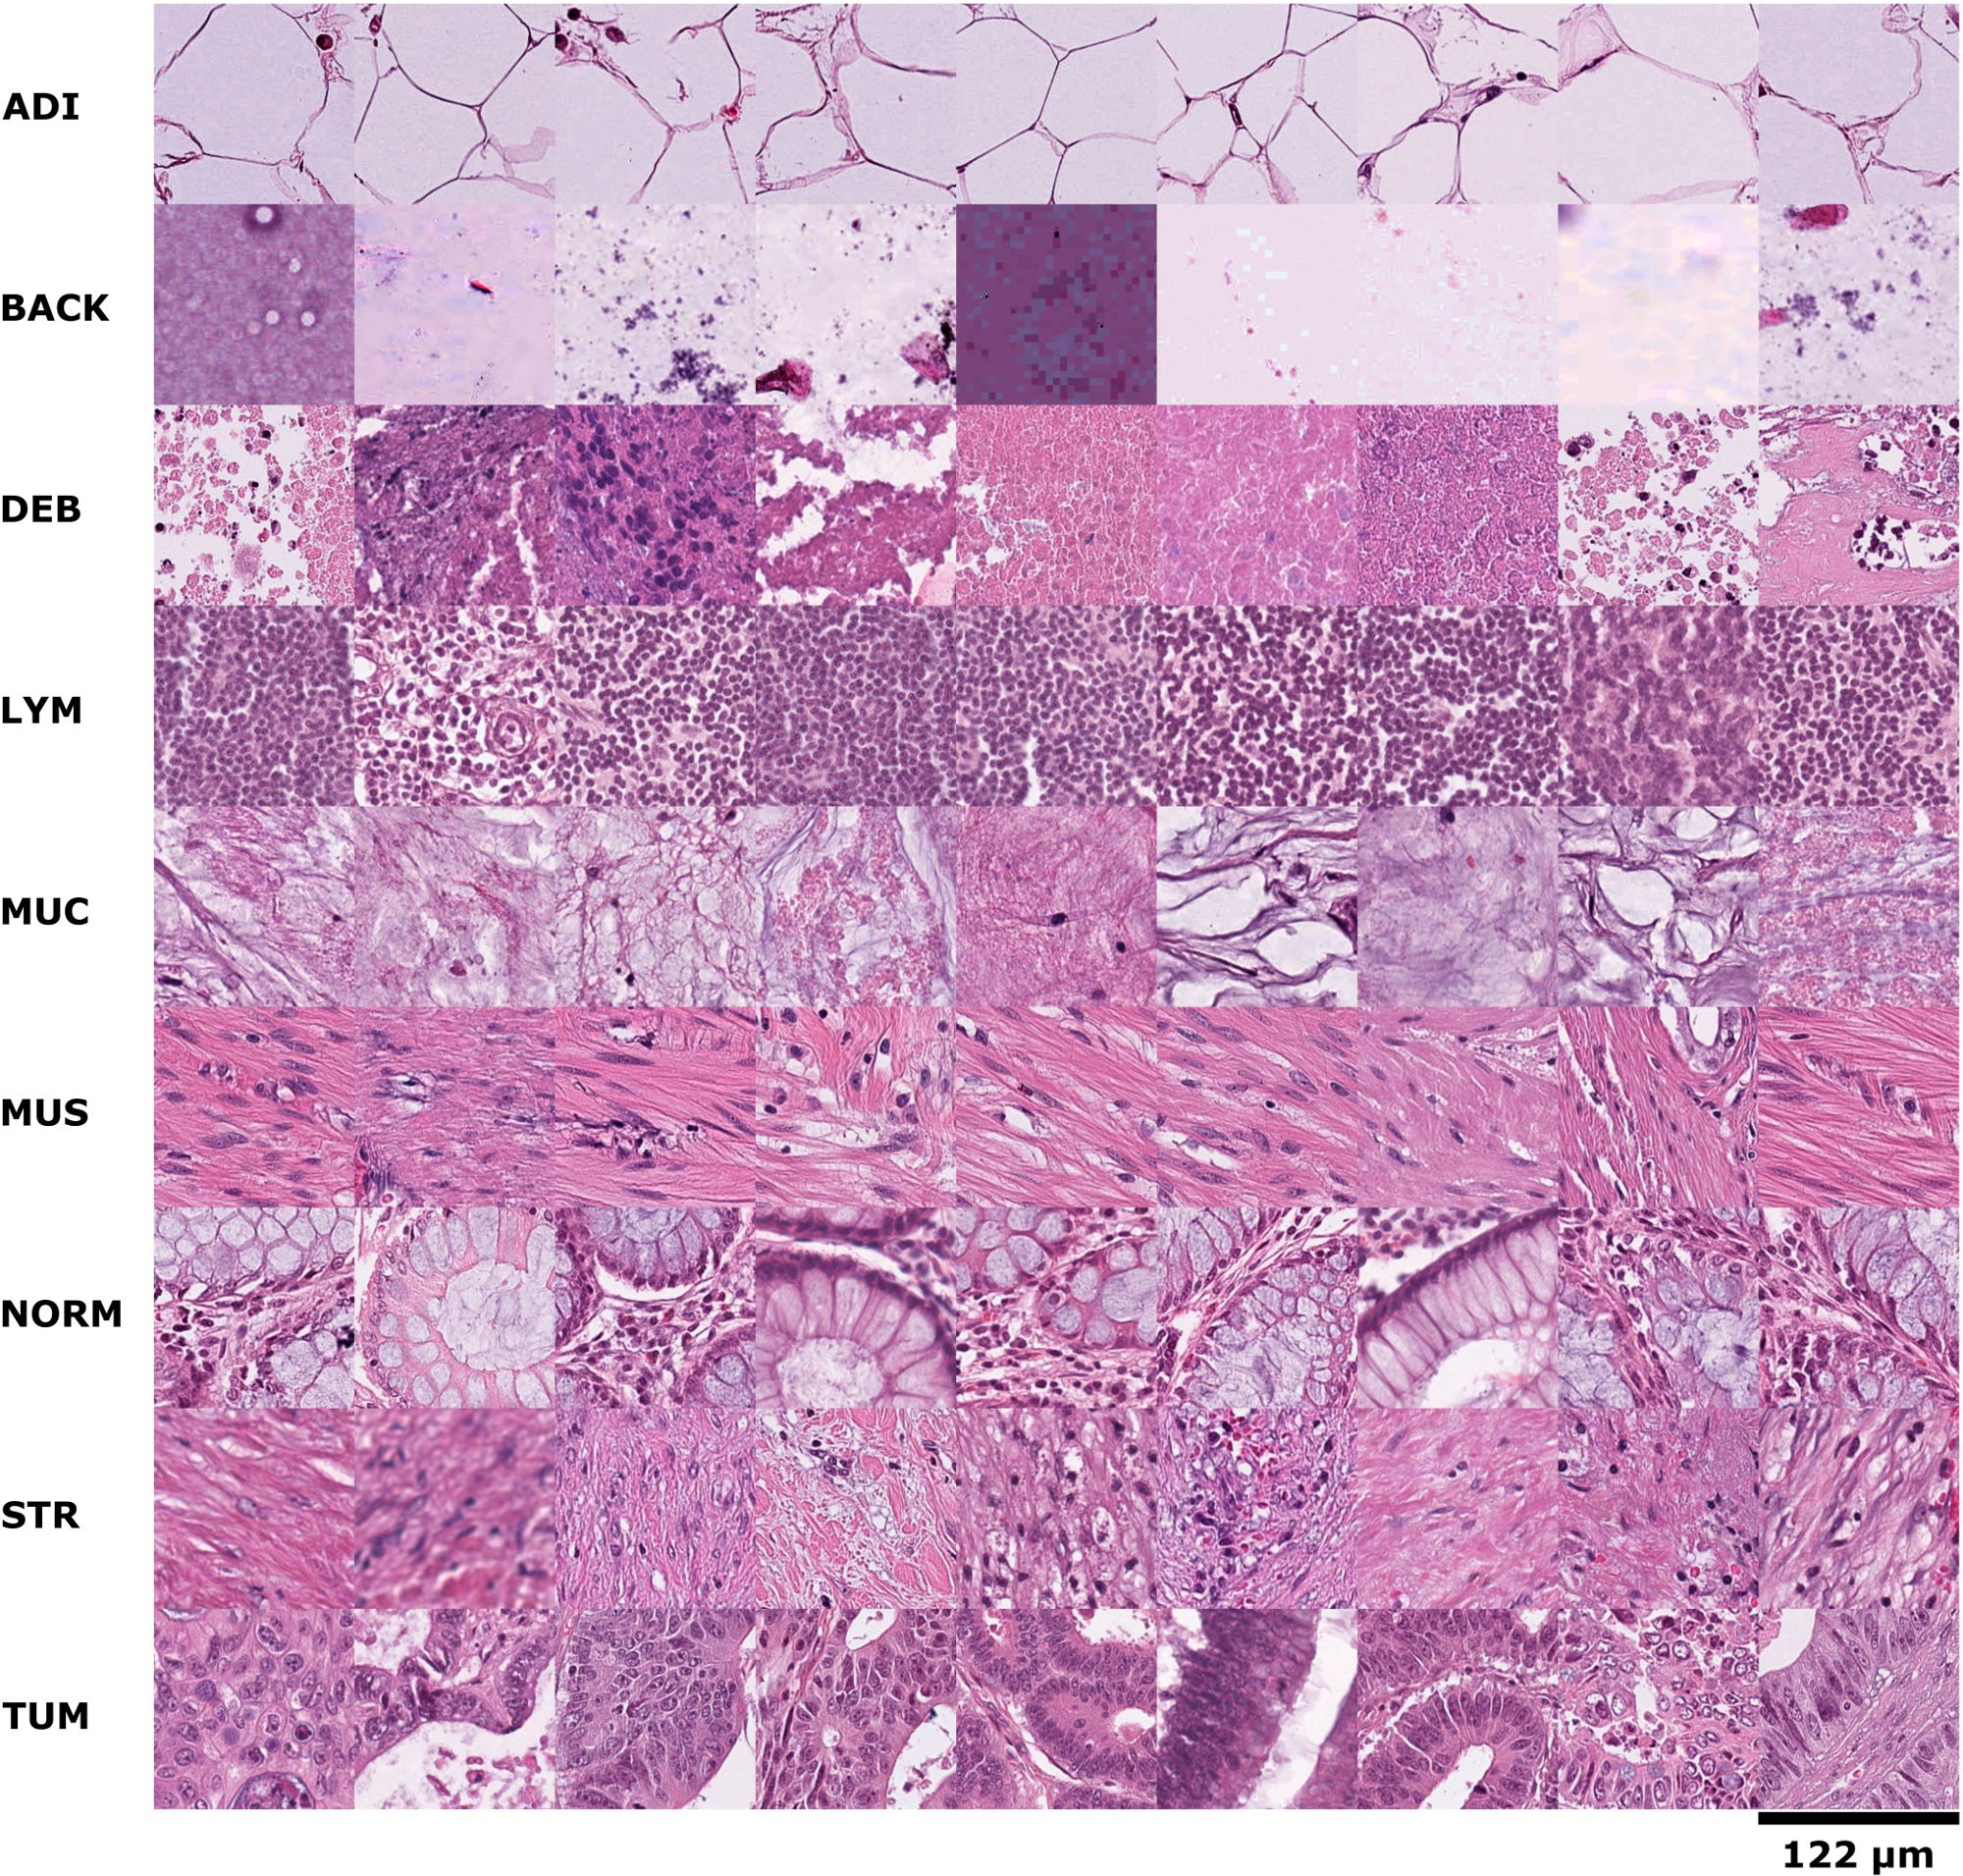

**Dataset Information:**

- You should respect the following traininig/validation/test split. Avoid overfitting.
- The data is available at: https://zenodo.org/record/5208230/files/pathmnist.npz.	
- You should evaluate the models using the balanced accuracy.

## Deadline

Sunday, June 19th 11:59pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you did, your grade will be penalized as follows:
- June 20th 11:59pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd 'drive/MyDrive/Colab Notebooks/mo444-machine-learning/t3'

/content/drive/MyDrive/Colab Notebooks/mo444-machine-learning/t3


In [ ]:
# Download dataset
! wget https://zenodo.org/record/5208230/files/pathmnist.npz

--2022-06-20 01:54:58--  https://zenodo.org/record/5208230/files/pathmnist.npz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205615438 (196M) [application/octet-stream]
Saving to: ‘pathmnist.npz’

pathmnist.npz       100%[===================>] 196.09M  22.8MB/s    in 9.0s    

2022-06-20 01:55:08 (21.8 MB/s) - ‘pathmnist.npz’ saved [205615438/205615438]



## Library imports

In [ ]:
!pip install pytorch_lightning torchvision torchsummary torch matplotlib numpy scikit-learn seaborn tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 69.7 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 419 kB 71.4 MB/s 
     |████████████████████████████████| 1.1 MB 61.7 MB/s 
     |████████████████████████████████| 271 kB 63.7 MB/s 
     |████████████████████████████████| 94 kB 5.1 MB/s 
     |████████████████████████████████| 144 kB 75.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Prepare data to use with SKLearn

In [ ]:
# preparing data to use with sklearn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
import time

In [ ]:
# loading the dataset

pathmnist = np.load('pathmnist.npz')

Splitting the entire dataset into *training*, *validation*, and *test* datasets:

In [ ]:
x_train, y_train = pathmnist['train_images'], pathmnist['train_labels']
x_val, y_val = pathmnist['val_images'], pathmnist['val_labels']
x_test, y_test = pathmnist['test_images'], pathmnist['test_labels']

Let's define a convenient function to show a few images of a given dataset.

In [ ]:
# we have 9 classes ranging from 0 to 8, following are their string representations

label_names = [
  "ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", "STR", "TUM"
]

def plot_dataset_with_labels(x_datapoints, y_labels):
  """
  Just pass a loaded dataset as x_datapoints and its labels as y_labels.
  """
  figure = plt.figure(figsize=(10,7))
  squeezed_y_train = y_labels.squeeze()
  for i in range(15):  
      axis_subplot = figure.add_subplot(3, 5, i+1)
      axis_subplot.imshow(x_datapoints[i])
      label = label_names[squeezed_y_train[i]]
      axis_subplot.set_title(f"Label ({squeezed_y_train[i]}) {label}")
      plt.axis('off')

Following is a small sample of the training dataset.

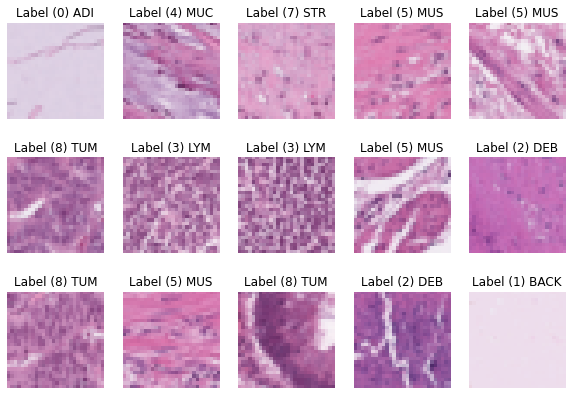

In [ ]:
plot_dataset_with_labels(x_train, y_train)

Following is a small sample of the validation dataset.

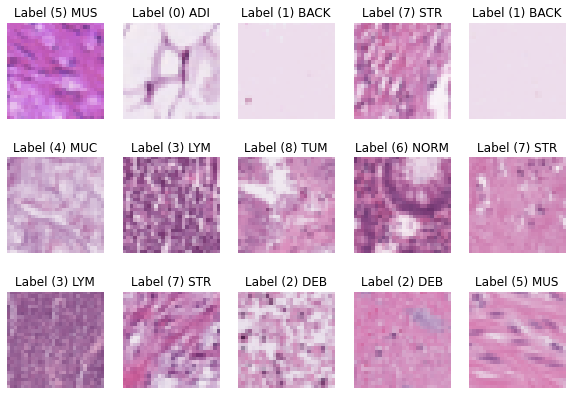

In [ ]:
plot_dataset_with_labels(x_val, y_val)

Following is a small sample of the test dataset.

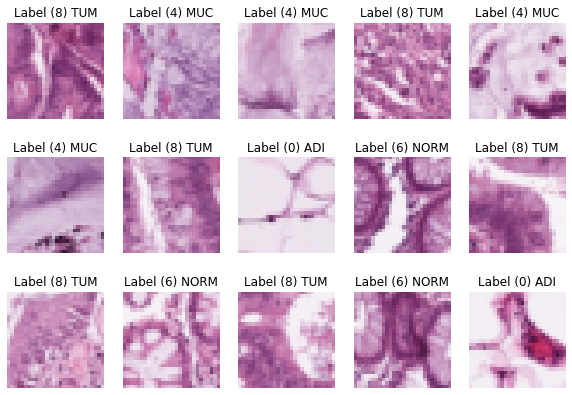

In [ ]:
plot_dataset_with_labels(x_test, y_test)

Our datasets have images with 28x28 pixels and red-green-blue (RGB) color channels, which gives a total of 3 channels per pixel with 8 bits each, ranging from 0 to 255 (8 bits unsigned int -> uint8). The quantity of images in each dataset is divided as follows:

*   Training: 89,996 images
*   Validation: 10,004 images
*   Test: 7,180 images

They are represented using the following dimensions in numpy:

In [ ]:
(
    x_train.shape, x_train.dtype, 
    x_val.shape, x_val.dtype, 
    x_test.shape, x_val.dtype
)

((89996, 28, 28, 3),
 dtype('uint8'),
 (10004, 28, 28, 3),
 dtype('uint8'),
 (7180, 28, 28, 3),
 dtype('uint8'))

In [ ]:
x_train_array = x_train.reshape(x_train.shape[0], -1)
x_val_array = x_val.reshape(x_val.shape[0], -1)
x_test_array = x_test.reshape(x_test.shape[0], -1)
(
    x_train_array.shape, x_train_array.dtype, 
    x_val_array.shape, x_val_array.dtype, 
    x_test_array.shape, x_val_array.dtype
)

((89996, 2352),
 dtype('uint8'),
 (10004, 2352),
 dtype('uint8'),
 (7180, 2352),
 dtype('uint8'))

The loaded labels have one dimension for each image with just a single number (the corresponding class). This is equivalent to having a simple array.

In [ ]:
(
    y_train.shape, y_train.dtype, 
    y_val.shape, y_val.dtype, 
    y_test.shape, y_val.dtype
)

((89996, 1),
 dtype('uint8'),
 (10004, 1),
 dtype('uint8'),
 (7180, 1),
 dtype('uint8'))

So we will squeeze this information into a simple array which is more convenient to perform our operations.

In [ ]:
y_train_array = y_train.squeeze()
y_val_array = y_val.squeeze()
y_test_array = y_test.squeeze()
(
    y_train_array.shape, y_train_array.dtype, 
    y_val_array.shape, y_val_array.dtype, 
    y_test_array.shape, y_val_array.dtype
)

((89996,), dtype('uint8'), (10004,), dtype('uint8'), (7180,), dtype('uint8'))

## Prepare data to use with PyTorch

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class PathMNIST(Dataset):
    def __init__(self, mode="train", transform=None):
      pathmnist = np.load('pathmnist.npz')
      if mode == "train":
        x, y = pathmnist['train_images'], pathmnist['train_labels']
      elif mode == "val":
        x, y = pathmnist['val_images'], pathmnist['val_labels']
      elif mode == "test":
        x, y = pathmnist['test_images'], pathmnist['test_labels']
      else:
        raise ValueError("Invalid mode.")

      self._x = x
      self._y = y.squeeze()
      self._transform = transform

    def __len__(self):
      return self._x.shape[0]

    def __getitem__(self, idx):
      item = self._x[idx]
      label = self._y[idx]
      if self._transform is not None:
        item = self._transform(item)
      item = item.flatten()
      return item, label

## Create PyTorch DataLoaders

In [ ]:
train_set = PathMNIST(mode="train", transform=ToTensor())
val_set = PathMNIST(mode="val", transform=ToTensor())
test_set = PathMNIST(mode="test", transform=ToTensor())

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)
test_loader = DataLoader(test_set, batch_size=1)

## SKLearn Preprocessing

Scalling the data: normalizing and centralizing the datapoints around 0, so data will range in the interval (-0.5, 0.5).
This will also converts the datatype from uint8 to float64, which is the sklearn LinearRegression optimized for.

In [ ]:
x_train_scaled_array = (x_train_array/255) - .5
x_val_scaled_array = (x_val_array/255) - .5
x_test_scaled_array = (x_test_array/255) -.5
(
    x_train_scaled_array[0].dtype, 
    x_val_scaled_array[0].dtype, 
    x_test_scaled_array[0].dtype
)

(dtype('float64'), dtype('float64'), dtype('float64'))

Let's just take a look of how the class labels are divided per quantity of images in each class in the test dataset.

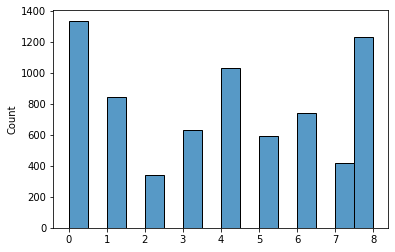

In [ ]:
sns.histplot(y_test_array)

## Activities


### 1. Logistic Regression
(2 points) Perform Multinomial Logistic Regression (_i.e._, softmax regression). It is a generalization of Logistic Regression to the case where we want to handle multiple classes. 

In order to explore different techniques for our image classification task, we are going to start with a simple one, the Logistic Regression. In fact, the model we will examinate first is a kind of generalization of the classic binary Logistic Regression and is typically used for multiple classes classifications, the so called *Multinomial Logistic Regression*.

Let's take a brief overview of the method, and for that, the diagram below provides a nicely visualization of how it works.

![picture](https://drive.google.com/uc?id=1KU1R-4RIDpA_mpIoksr2suNGzUl_tZAK)

**Diagram:** Softmax Regression Schema

To understand what is going on, we should maybe think of this diagram as a single layer neural network. In that way, each neuron of the layer represents a different class, from an amount of $h$ classes. The inputs of the layer are the classic linear combinations of weights and feature vectors ($m$ is representing the number of features), and at the end, there is an activation process where we use the softmax function, which is defined below:

$$
P(y = t | z_t^{[i]}) = \theta_{softmax}(z_t^{[i]})=\frac{e^{z_t^{[i]}}}{\sum_{j=1}^{h}e^{z_j^{[i]}}} = a_j^{[i]}
$$

In the equations above, $ t \in (1, ..., h)$ and $ i \in (1, ..., N)$, where $N$ is the number of datapoints in the batch. 

Essentially, softmax is just an exponential function that normalizes the activations in a way that they sum up to 1. By doing that, the $a_j$ activations are now representing the class-membership probabilities, the classes are being treated as mutually exclusive, and at the end we come up with a vector of probabilities for each class as the output. Then, the $i$-th entry of the vector with the highest probability will be chosen as the predicted label. This is a more appropriate procedure, instead of using the sigmoid function, for instance, which doesn't provide exclusive class-membership probabilities (and the activations don't sum up to 1).

The cost function to be minimized, just like in the binary logistic regression, is the negative log-likelihood loss (equivalent to cross-entropy). It is defined below: 

$$
J(w) := \frac{1}{N}{\sum_{i=1}^{N}\sum_{j=1}^{h}-y_j^{[i]}}ln(a_j^{[i]})  
$$

In the equation above, it is assumed that the labels were one-hot encoded, so each $y_j$ only assumes 1 at the entry corresponding to its label, and 0 otherwise. For the implementation, we don't have to worry about that because we're going to use libraries that perform the OHE automatically for us.

The code implemenation for the Softmax Regression, using SkLearn, is showed as follows.

In [ ]:
class PathMNISTLR():
    def __init__(self):
        self.clf = LogisticRegression(
            multi_class="multinomial", 
            solver="sag",
            verbose=1
        )
    
    def fit(self, x_dataset, y_labels):
        self.clf.fit(x_dataset, y_labels)
    
    def predict(self, x_dataset):
        return self.clf.predict(x_dataset)

    def save_model(self, filename):
        pickle.dump(self.clf, open(filename, 'wb'))
    
    def load_model(self, filename):
        self.clf = pickle.load(open(filename, 'rb'))

    def score(self, x_dataset, y_true):
        y_pred = self.predict(x_dataset)
        return balanced_accuracy_score(y_true, y_pred)
    
    def confusion_matrix(self, x_dataset, y_true):
        """
        calculate the confusion matrix
        """
        y_pred = self.predict(x_dataset)
        return confusion_matrix(y_true, y_pred)

    def plot_confusion_matrix(self, matrix):
        """
        plot the confusion matrix with a graphical representation
        """
        plt.matshow(matrix, cmap=plt.cm.gray)
        plt.show()

Fits the Linear Regression model from scratch:

In [ ]:
lr_cls = PathMNISTLR()
lr_cls.fit(x_train_scaled_array, y_train_array)
lr_cls.save_model("softmax-multinomial-sag")

Loads the Linear Regression model from a pre-saved file:

In [ ]:
lr_cls = PathMNISTLR()
lr_cls.load_model("softmax-multinomial-sag")

Computes the balanced accuracy in the test dataset.

In [ ]:
print(f"Test balanced accuracy: {lr_cls.score(x_test_scaled_array, y_test_array)}")

Test balanced accuracy: 0.512338674923024


Computes and plots the confusion matrix.

In [ ]:
conf_matrix = lr_cls.confusion_matrix(x_test_scaled_array, y_test_array)

Text(69.0, 0.5, 'True Labels')

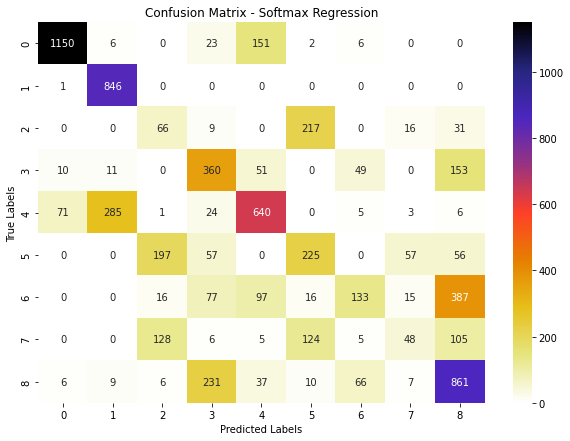

In [ ]:
plt.figure(figsize = (10, 7))
sns.heatmap(conf_matrix, cmap = 'CMRmap_r', annot = True, fmt = '.0f')
plt.title('Confusion Matrix - Softmax Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


> What are the conclusions? (1-2 paragraphs)




For the logistic regression implementation, we used SKlearn to perform the training, choosing the multinomial case (which uses cross-entropy loss function) and SAG optimizer as solver. Also, the maximum number of iterations was left settled as 100 by default. We got a balanced accuracy in the test dataset of approximately 51.2%, which is far way from good. Indeed, when we look at the confusion matrix, we can clearly visualize that for some classes the model is providing very bad predictions. We even tried to improve the performance of the model by using cross validation techniques (we tried the K-fold method), but the simplest model implemented above is the one who ended up with the best result (or the least worst, in this case). 

However, that's not a big surprise at all. Altough the multiclass logistic regression is designed in a way that offers a joynable and easy interpretability, and tries to maximize the class-membership probabilities, it has its own limitations. Definitely one of the major limitations is due to the assumption of a linear relationship between the dependent variable (the true label) and the independent variables (the weights/feature vectors). It turns out that the problem we're dealing with is complex enough to just reduce it into a linear relation between the features and to use an unique layer. We have a large number of features per image and an even larger number of datapoints, so try to capture their dependency format by assuming linearity is way too simple and optimistic. So, we're not going to get much frustrated with that result and instead we may take it as a prelude/baseline to the next models, which are certainly more complexes. We aim to get better results by getting better approaches, such as multilayer perceptrons and neural networs with more sophisticated architectures. So let's dive into it.


### 2. Neural Networks
(2 points) Move on to Neural Networks, using _one_ or _two hidden layers_. You should choose weight & bias initialization, activation function, number of hidden neurons, loss function, ... keep it simple.


After the simple NN explore more two differents architectures. You can change weight & bias initialization, activation function, number of hidden neurons, number of layers, loss function, ... It's an empirical experiment.  

Now we're entering the wide neural networks' world. But to start, we're going to keep things as simple as possible.

For the first model, we'll be using a neural network with just one hidden layer, composed by 150 neurons. We'll be training the model for 100 epochs, and also will be using the sigmoid as activation function. Since this is just an exploitation, there's no science behind those choices.

We're going to use the PyTorch API module, and also the GPU in order to get our trainings faster.

Let's get started with some settings for the parameters.

In [ ]:
# Initial settings and Loadings for PyTorch

import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# MACROs

RANDOM_SEED = 1
BATCH_SIZE = 256
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # setting up the GPU for usage

# PyTorch data loadings

train_dataset = PathMNIST(mode="train", transform=ToTensor())
val_dataset = PathMNIST(mode="val", transform=ToTensor())
test_dataset = PathMNIST(mode="test", transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

In [ ]:
# Verification of the train dataset

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 2352])
Image label dimensions: torch.Size([256])


In [ ]:
class NN_1st_version(torch.nn.Module):

    def __init__(self, num_features, num_neurons, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        # 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_neurons)
        self.linear_1.weight.detach().normal_(0.0, 0.1) # normalized initialization of the weights
        self.linear_1.bias.detach().zero_() # and bias

        # output layer
        self.linear_out = torch.nn.Linear(num_neurons, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out) 
        logits = self.linear_out(out)
        return logits

torch.manual_seed(RANDOM_SEED)
model = NN_1st_version(num_features=28*28*3,
            num_neurons=150,
            num_classes=9)

# Model and Optmizer

model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # optimizer algorithm to be used: SGD; learning rate := 0.1

# Training

def compute_loss(net, data_loader):
    """
    Defines loss computations
    """
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, labels) in enumerate(data_loader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, labels)
            curr_loss += loss
        return float(curr_loss)/cnt

start_time = time.time()
minibatch_loss = []
epoch_loss = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = model(features)
        
        cost_function = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        cost_function.backward()
       
        # Update model parameters
        optimizer.step()
        
        # Prints for each batch update
        minibatch_loss.append(cost_function.item())
        if not batch_idx % 50: # prints the batch updates from 50 to 50 
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost_function.item()))
        
    cost = compute_loss(model, train_loader)
    epoch_loss.append(cost)

    # Print for an entire epoch update
    print('Epoch: %03d/%03d | Epoch Loss: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time spent: %.2f min' % ((time.time() - start_time)/60))
    
# End of training time info
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/352 | Loss: 2.4154
Epoch: 001/100 | Batch 050/352 | Loss: 2.0757
Epoch: 001/100 | Batch 100/352 | Loss: 1.9636
Epoch: 001/100 | Batch 150/352 | Loss: 1.9620
Epoch: 001/100 | Batch 200/352 | Loss: 1.8732
Epoch: 001/100 | Batch 250/352 | Loss: 1.8192
Epoch: 001/100 | Batch 300/352 | Loss: 1.9459
Epoch: 001/100 | Batch 350/352 | Loss: 1.9361
Epoch: 001/100 | Epoch Loss: 1.9422
Time spent: 0.11 min
Epoch: 002/100 | Batch 000/352 | Loss: 1.8417
Epoch: 002/100 | Batch 050/352 | Loss: 1.8240
Epoch: 002/100 | Batch 100/352 | Loss: 1.8267
Epoch: 002/100 | Batch 150/352 | Loss: 1.8726
Epoch: 002/100 | Batch 200/352 | Loss: 1.7860
Epoch: 002/100 | Batch 250/352 | Loss: 1.6572
Epoch: 002/100 | Batch 300/352 | Loss: 1.8079
Epoch: 002/100 | Batch 350/352 | Loss: 1.7644
Epoch: 002/100 | Epoch Loss: 1.6905
Time spent: 0.23 min
Epoch: 003/100 | Batch 000/352 | Loss: 1.7319
Epoch: 003/100 | Batch 050/352 | Loss: 1.8620
Epoch: 003/100 | Batch 100/352 | Loss: 1.7734
Epoch: 003/1

Let's visualize the plots for the losses.

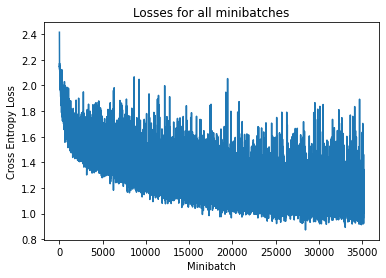

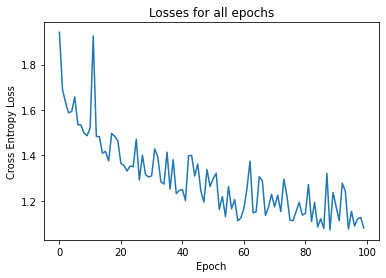

In [ ]:
# Plots for the Cross Entropy

plt.plot(range(len(minibatch_loss)), minibatch_loss)
plt.title('Losses for all minibatches')
plt.xlabel('Minibatch')
plt.ylabel('Cross Entropy Loss')
plt.show()

plt.plot(range(len(epoch_loss)), epoch_loss)
plt.title('Losses for all epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

And now let's verify the accuracies.

In [ ]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 59.38
Test Accuracy: 61.94


This first result shows us that the accuracy has improved about 10% when compared to Multinomial Logistic Regression.

For the next model, let's first verify if there is any improvement by just adding a second hidden layer.

In [ ]:
class NN_2nd_version(torch.nn.Module):

    def __init__(self, num_features, num_neurons, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        # 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_neurons)
        self.linear_1.weight.detach().normal_(0.0, 0.1) # normalized initialization of the weights
        self.linear_1.bias.detach().zero_() # and bias

        # 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_neurons, 75)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()

        # output layer
        self.linear_out = torch.nn.Linear(75, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        out = self.linear_2(out)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        return logits

torch.manual_seed(RANDOM_SEED)
model = NN_2nd_version(num_features=28*28*3,
            num_neurons=150,
            num_classes=9)

# Model and Optmizer

model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # optimizer algorithm to be used: SGD; learning rate := 0.1

# Training

def compute_loss(net, data_loader):
    """
    Defines loss computations
    """
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, labels) in enumerate(data_loader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, labels)
            curr_loss += loss
        return float(curr_loss)/cnt

start_time = time.time()
minibatch_loss = []
epoch_loss = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = model(features)
        
        cost_function = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        cost_function.backward()
       
        # Update model parameters
        optimizer.step()
        
        # Prints for each batch update
        minibatch_loss.append(cost_function.item())
        if not batch_idx % 50: # prints the batch updates from 50 to 50 
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost_function.item()))
        
    cost = compute_loss(model, train_loader)
    epoch_loss.append(cost)

    # Print for an entire epoch update
    print('Epoch: %03d/%03d | Epoch Loss: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time spent: %.2f min' % ((time.time() - start_time)/60))
    
# End of training time info
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/352 | Loss: 2.2818
Epoch: 001/100 | Batch 050/352 | Loss: 2.2131
Epoch: 001/100 | Batch 100/352 | Loss: 2.1709
Epoch: 001/100 | Batch 150/352 | Loss: 2.1769
Epoch: 001/100 | Batch 200/352 | Loss: 2.1903
Epoch: 001/100 | Batch 250/352 | Loss: 2.1564
Epoch: 001/100 | Batch 300/352 | Loss: 2.1345
Epoch: 001/100 | Batch 350/352 | Loss: 2.1313
Epoch: 001/100 | Epoch Loss: 2.1396
Time spent: 0.11 min
Epoch: 002/100 | Batch 000/352 | Loss: 2.1238
Epoch: 002/100 | Batch 050/352 | Loss: 2.1143
Epoch: 002/100 | Batch 100/352 | Loss: 2.0636
Epoch: 002/100 | Batch 150/352 | Loss: 2.0611
Epoch: 002/100 | Batch 200/352 | Loss: 2.0658
Epoch: 002/100 | Batch 250/352 | Loss: 1.9405
Epoch: 002/100 | Batch 300/352 | Loss: 1.9211
Epoch: 002/100 | Batch 350/352 | Loss: 1.9419
Epoch: 002/100 | Epoch Loss: 1.9165
Time spent: 0.22 min
Epoch: 003/100 | Batch 000/352 | Loss: 1.8925
Epoch: 003/100 | Batch 050/352 | Loss: 1.8972
Epoch: 003/100 | Batch 100/352 | Loss: 1.9148
Epoch: 003/1

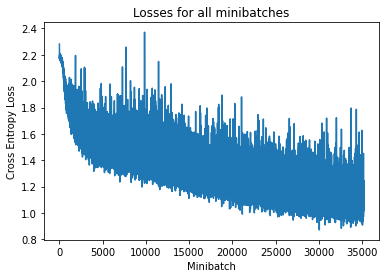

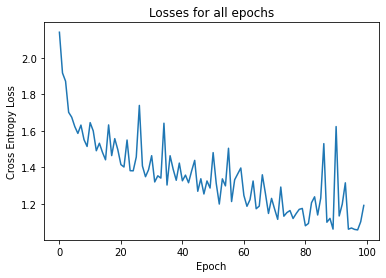

In [ ]:
# Plots for the Cross Entropy

plt.plot(range(len(minibatch_loss)), minibatch_loss)
plt.title('Losses for all minibatches')
plt.xlabel('Minibatch')
plt.ylabel('Cross Entropy Loss')
plt.show()

plt.plot(range(len(epoch_loss)), epoch_loss)
plt.title('Losses for all epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 55.02
Test Accuracy: 62.48


We can assume that the accuracy dindn't changed at all.

So, our last try will be back to one single hidden layer, but now with 500 neurons. In the SGD solver we're going to add a momentum. Let's keep the cost function as being the cross entropy. Also, we'll be training for 60 epochs instead of 100.

In [ ]:
class NN_3rd_version(torch.nn.Module):

    def __init__(self, num_features, num_neurons, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        # 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_neurons)
        self.linear_1.weight.detach().normal_(0.0, 0.1) # normalized initialization of the weights
        self.linear_1.bias.detach().zero_() # and bias

        # output layer
        self.linear_out = torch.nn.Linear(num_neurons, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        return logits

torch.manual_seed(RANDOM_SEED)
model = NN_3rd_version(num_features=28*28*3,
            num_neurons=500,
            num_classes=9)

# Model and Optmizer

model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # optimizer algorithm to be used: SGD; learning rate := 0.1

# Training

def compute_loss(net, data_loader):
    """
    Defines loss computations
    """
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, labels) in enumerate(data_loader):
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, labels)
            curr_loss += loss
        return float(curr_loss)/cnt

start_time = time.time()
minibatch_loss = []
epoch_loss = []
for epoch in range(60):
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        logits = model(features)
        
        cost_function = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        cost_function.backward()
       
        # Update model parameters
        optimizer.step()
        
        # Prints for each batch update
        minibatch_loss.append(cost_function.item())
        if not batch_idx % 50: # prints the batch updates from 50 to 50 
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, 60, batch_idx, 
                     len(train_loader), cost_function.item()))
        
    cost = compute_loss(model, train_loader)
    epoch_loss.append(cost)

    # Print for an entire epoch update
    print('Epoch: %03d/%03d | Epoch Loss: %.4f' % (
            epoch+1, 60, cost))
    print('Time spent: %.2f min' % ((time.time() - start_time)/60))
    
# End of training time info
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/060 | Batch 000/352 | Loss: 2.7508
Epoch: 001/060 | Batch 050/352 | Loss: 2.0496
Epoch: 001/060 | Batch 100/352 | Loss: 1.7527
Epoch: 001/060 | Batch 150/352 | Loss: 1.7893
Epoch: 001/060 | Batch 200/352 | Loss: 1.6936
Epoch: 001/060 | Batch 250/352 | Loss: 1.5842
Epoch: 001/060 | Batch 300/352 | Loss: 1.5581
Epoch: 001/060 | Batch 350/352 | Loss: 2.0239
Epoch: 001/060 | Epoch Loss: 1.9809
Time spent: 0.11 min
Epoch: 002/060 | Batch 000/352 | Loss: 2.0314
Epoch: 002/060 | Batch 050/352 | Loss: 1.8221
Epoch: 002/060 | Batch 100/352 | Loss: 1.7736
Epoch: 002/060 | Batch 150/352 | Loss: 1.6633
Epoch: 002/060 | Batch 200/352 | Loss: 1.6431
Epoch: 002/060 | Batch 250/352 | Loss: 1.6292
Epoch: 002/060 | Batch 300/352 | Loss: 1.7617
Epoch: 002/060 | Batch 350/352 | Loss: 1.8174
Epoch: 002/060 | Epoch Loss: 1.6689
Time spent: 0.22 min
Epoch: 003/060 | Batch 000/352 | Loss: 1.6686
Epoch: 003/060 | Batch 050/352 | Loss: 1.9216
Epoch: 003/060 | Batch 100/352 | Loss: 1.6255
Epoch: 003/0

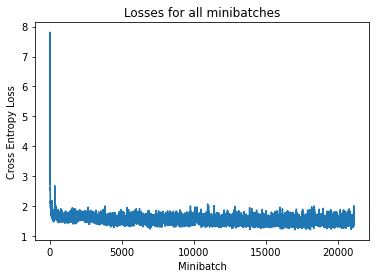

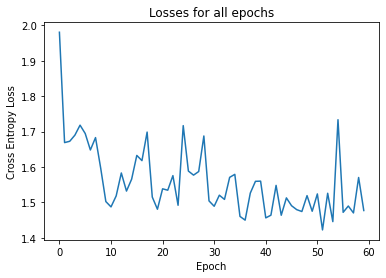

In [ ]:
# Plots for the Cross Entropy

plt.plot(range(len(minibatch_loss)), minibatch_loss)
plt.title('Losses for all minibatches')
plt.xlabel('Minibatch')
plt.ylabel('Cross Entropy Loss')
plt.show()

plt.plot(range(len(epoch_loss)), epoch_loss)
plt.title('Losses for all epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [ ]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 45.23
Test Accuracy: 51.80


> What are the conclusions? (1-2 paragraphs)

The best MLP approach brought to us an accuracy of about 62%, which is better than the Multinomial Logistic Regression, however indicates that it may not be sufficient to our problem. 

### 3. Image Processing
(1 point) Apply image preprocessing techniques to improve the performance of the last neural network (for example, convert RGB image (3 channel) to grayscale (1 channel), standardization, normalization).

See: https://scikit-image.org/ and https://opencv.org/

Explore some geometric, morphological and textures transformations.



In [ ]:
# TODO: Image processing and Neural Network. You can use scikit-learn, Keras/TensorFlow, or PyTorch libraries.

> What are the conclusions? Regarding the first architecture, does the performance improve? (2-4 paragraphs)

Unfortunately, we didn't get enough time to explore this =(

### 4. Convolutional Neural Networks
(2 points) Build and train a convolutional neural network for data classification using the dataloader presented below. You CAN use the Keras library to build the model. Beware of overfitting!
Apply a weight regularization to avoid overfitting and improve the performance of the neural network (for example, l1, l2, l1 and l2).

Since we didn't get very good results yet, we'll try to change this scenario using Convolutional Neural Networks (CNNs).

Our approach implementation is showed as follows.

In [ ]:
#Use this code -- You do not need to change it!
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from keras.models import load_model

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# creating custom data loader to use with CNN in Keras
class PathMNISTCNN(tf.keras.utils.Sequence):
  def __init__(self, mode="train", batch_size=32, n_classes=9, shuffle=True, seed=42):
    pathmnist = np.load('pathmnist.npz')

    if mode == "train":
      x, y = pathmnist['train_images'], pathmnist['train_labels']
    elif mode == "val":
      x, y = pathmnist['val_images'], pathmnist['val_labels']
    elif mode == "test":
      x, y = pathmnist['test_images'], pathmnist['test_labels']
    else:
      raise ValueError("Invalid mode. Accepted modes: train, val, test")
    self._x = x
    self._y = y.squeeze()
    self.batch_size = batch_size
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.random_seed = seed


  def on_epoch_end(self):
    pass


  def __len__(self):
    return self._x.shape[0]//self.batch_size
  

  def __getitem__(self, idx):
    if(self.shuffle):
      self._x, self._y = shuffle(self._x, self._y, random_state=self.random_seed)

    images, labels = [], []
    for i in range(idx*self.batch_size, (idx+1)*self.batch_size):
      images.append(self._x[i])
      y = [0 if c != self._y[i] else 1 for c in range(self.n_classes)]
      labels.append(y)
    return np.array(images), np.array(labels)

In [ ]:
train_data_cnn = PathMNISTCNN(mode="train")
val_data_cnn = PathMNISTCNN(mode="val", shuffle=False)
test_data_cnn = PathMNISTCNN(mode="test", shuffle=False)

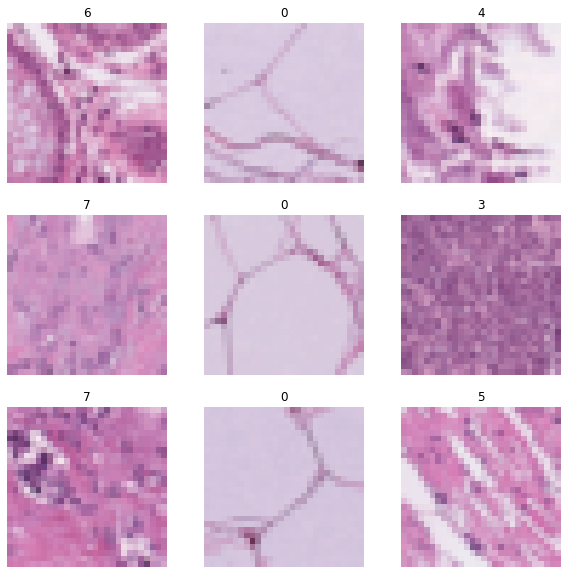

In [ ]:
import matplotlib.pyplot as plt
#data visualization
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_data_cnn):
  if(i==9):
    break
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(np.argmax(labels[i]))
  plt.axis("off")

In [ ]:
def cnn_model_1(input_shape, n_classes, activation_function):
    input = keras.Input(shape=input_shape+(3,))
    x = layers.Rescaling(1.0/255)(input)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(
        n_classes, 
        activation=activation_function,
        kernel_regularizer=keras.regularizers.l2(0.01)
    )(x)
    return keras.Model(input, output)

In [ ]:
activation_function = "softmax"

model1 = cnn_model_1(input_shape=(28,28), n_classes=9,
                     activation_function=activation_function)
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 28, 28, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                       

In [ ]:
epochs = 10
callbacks = [keras.callbacks.ModelCheckpoint('model1.h5', 
                                              monitor='val_loss', 
                                              save_best_only=True),]

sgd = keras.optimizers.SGD(learning_rate=0.001)

optimizer = sgd
loss = "categorical_crossentropy"
model1.compile(optimizer=optimizer, loss=loss,
               metrics=[
                        "accuracy", 
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
               ],)

In [ ]:
history1 = model1.fit(
    train_data_cnn, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_data_cnn,
)

Epoch 1/10
2812/2812 [==============================] - 161s 57ms/step - loss: 2.3379 - accuracy: 0.1663 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.2947 - val_accuracy: 0.2408 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/10
2812/2812 [==============================] - 157s 56ms/step - loss: 2.2193 - accuracy: 0.2336 - precision_4: 0.4107 - recall_4: 0.0013 - val_loss: 2.1195 - val_accuracy: 0.2380 - val_precision_4: 0.3669 - val_recall_4: 0.0113
Epoch 3/10
2812/2812 [==============================] - 158s 56ms/step - loss: 2.0566 - accuracy: 0.2533 - precision_4: 0.7000 - recall_4: 0.0570 - val_loss: 1.9995 - val_accuracy: 0.2631 - val_precision_4: 0.7291 - val_recall_4: 0.0784
Epoch 4/10
2812/2812 [==============================] - 158s 56ms/step - loss: 1.9536 - accuracy: 0.3039 - precision_4: 0.7312 - recall_4: 0.0805 - val_loss: 1.8924 - val_accuracy: 0.3650 - val_precision_4: 0.7194 - val_recall_4: 0.0852
Epoch 5/10
2812/2812 [==============

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [ ]:
results = model1.evaluate(test_data_cnn, batch_size=32)

224/224 [==============================] - 1s 4ms/step - loss: 1.1441 - accuracy: 0.6784 - precision_4: 0.8594 - recall_4: 0.3470


In [ ]:
model1_loaded = load_model("model1.h5")
model1_loaded.evaluate(test_data_cnn, batch_size=32)

224/224 [==============================] - 1s 5ms/step - loss: 1.1441 - accuracy: 0.6784 - precision_4: 0.8594 - recall_4: 0.3470


[1.1440714597702026,
 0.6784319281578064,
 0.8593642115592957,
 0.3469586968421936]

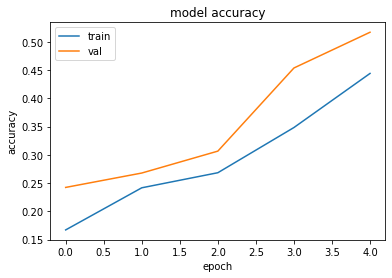

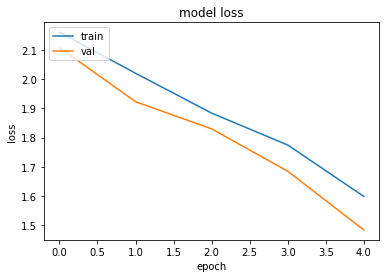

In [ ]:
plot_history(history1)

> What are the conclusions? Regarding the first architecture, does the performance improve? (2-4 paragraphs)

First of all, we can notice that the accuracy has improved a little bit, with 67.8% in the test set, which is really good since we've trained the model for 10 decades only. This may indicate that a suitable combination of convolutional layers, plus MaxPooling layers and then a dropout of 0.5 in the last layer does improve the model.  

As we expected, the CNN outperfomed the basic multilayer perceptron implementation, which has some compreensive limitations such as the assumption of independency between the features and the core of its prediction method being essentialy the sum of pixels intensities. In that way, we may assume that the CNN captured the complexity of the images in a better way. 

However, it took a considerable time for the training, which creates some barriers that are beyond our control taking into account that we have other parts in this task.

### 5. Upgrade your CNN
(1 point) Apply two update rules used to optimize Neural Networks (for example, Momentum, Adagrad, Adam, RMSProp, Adadelta). For reference, see http://ruder.io/optimizing-gradient-descent.

In [ ]:
def cnn_model_2(input_shape, n_classes, activation_function):
    input = keras.Input(shape=input_shape+(3,))
    x = layers.Rescaling(1.0/255)(input)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    output = layers.Dense(
        n_classes, 
        activation=activation_function,
        kernel_regularizer=keras.regularizers.l2(0.01)
    )(x)
    return keras.Model(input, output)

In [ ]:
activation_function = "softmax"

model2 = cnn_model_2(input_shape=(28,28), n_classes=9,
                     activation_function=activation_function)
model2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 28, 28, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                      

In [ ]:
epochs = 10
callbacks = [keras.callbacks.ModelCheckpoint('model2.h5', 
                                              monitor='val_loss', 
                                              save_best_only=True),]
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = "categorical_crossentropy" 
model2.compile(optimizer=optimizer, loss=loss,
               metrics=[
                        "accuracy", 
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
               ],)

In [ ]:
start_time = time.time()

history2 = model2.fit(train_data_cnn, epochs=epochs, callbacks=callbacks, 
                      validation_data=val_data_cnn,)

end_time = time.time()
print(f"Training took {end_time - start_time} seconds.")

Epoch 1/10
2812/2812 [==============================] - 160s 57ms/step - loss: 1.3051 - accuracy: 0.5455 - precision_7: 0.7745 - recall_7: 0.3198 - val_loss: 1.0639 - val_accuracy: 0.6606 - val_precision_7: 0.8402 - val_recall_7: 0.4230
Epoch 2/10
2812/2812 [==============================] - 159s 56ms/step - loss: 1.0322 - accuracy: 0.6508 - precision_7: 0.7934 - recall_7: 0.4886 - val_loss: 0.9067 - val_accuracy: 0.7062 - val_precision_7: 0.8514 - val_recall_7: 0.5428
Epoch 3/10
2812/2812 [==============================] - 158s 56ms/step - loss: 0.9499 - accuracy: 0.6863 - precision_7: 0.8083 - recall_7: 0.5445 - val_loss: 0.9663 - val_accuracy: 0.6799 - val_precision_7: 0.7990 - val_recall_7: 0.5486
Epoch 4/10
2812/2812 [==============================] - 158s 56ms/step - loss: 0.8955 - accuracy: 0.7065 - precision_7: 0.8198 - recall_7: 0.5828 - val_loss: 0.7825 - val_accuracy: 0.7564 - val_precision_7: 0.8800 - val_recall_7: 0.6198
Epoch 5/10
2812/2812 [==============================

In [ ]:
results2 = model2.evaluate(test_data_cnn, batch_size=32)

224/224 [==============================] - 1s 5ms/step - loss: 0.8384 - accuracy: 0.7737 - precision_7: 0.8399 - recall_7: 0.7121


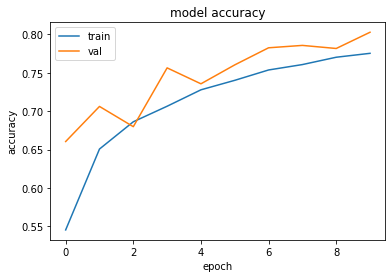

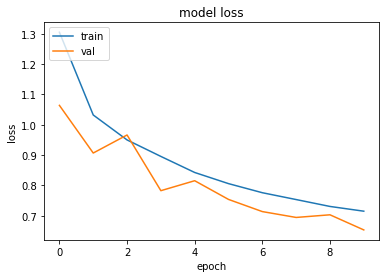

In [ ]:
plot_history(history2)

In [ ]:
def cnn_model_3(input_shape, n_classes, activation_function):
    input = keras.Input(shape=input_shape+(3,))
    x = layers.Rescaling(1.0/255)(input)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(
        n_classes, 
        activation=activation_function,
        kernel_regularizer=keras.regularizers.l2(0.01)
    )(x)
    return keras.Model(input, output)

In [ ]:
activation_function = "softmax"

model3 = cnn_model_3(input_shape=(28,28), n_classes=9,
                     activation_function=activation_function)
model3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 28, 28, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                      

In [ ]:
epochs = 10

callbacks = [keras.callbacks.ModelCheckpoint('model3.h5', 
                                              monitor='val_loss', 
                                              save_best_only=True),]
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
loss = "categorical_crossentropy"
model3.compile(optimizer=optimizer, loss=loss,
               metrics=[
                        "accuracy", 
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
               ],)

In [ ]:
start_time = time.time()

history3 = model3.fit(train_data_cnn, epochs=epochs, callbacks=callbacks, 
                      validation_data=val_data_cnn,)

end_time = time.time()
print(f"Training took {end_time - start_time} seconds.")

Epoch 1/10
2812/2812 [==============================] - 162s 58ms/step - loss: 1.1711 - accuracy: 0.6176 - precision_9: 0.7654 - recall_9: 0.4504 - val_loss: 1.0280 - val_accuracy: 0.6787 - val_precision_9: 0.8243 - val_recall_9: 0.5066
Epoch 2/10
2812/2812 [==============================] - 161s 57ms/step - loss: 1.0798 - accuracy: 0.6595 - precision_9: 0.7837 - recall_9: 0.5175 - val_loss: 1.0921 - val_accuracy: 0.6715 - val_precision_9: 0.8164 - val_recall_9: 0.5299
Epoch 3/10
2812/2812 [==============================] - 161s 57ms/step - loss: 1.0165 - accuracy: 0.6925 - precision_9: 0.8015 - recall_9: 0.5677 - val_loss: 0.9119 - val_accuracy: 0.7401 - val_precision_9: 0.8505 - val_recall_9: 0.6096
Epoch 4/10
2812/2812 [==============================] - 160s 57ms/step - loss: 0.9655 - accuracy: 0.7146 - precision_9: 0.8127 - recall_9: 0.6029 - val_loss: 0.8756 - val_accuracy: 0.7617 - val_precision_9: 0.8640 - val_recall_9: 0.6288
Epoch 5/10
2812/2812 [==============================

In [ ]:
results3 = model3.evaluate(test_data_cnn, batch_size=32)

224/224 [==============================] - 1s 5ms/step - loss: 1.0942 - accuracy: 0.7313 - precision_9: 0.7726 - recall_9: 0.6812


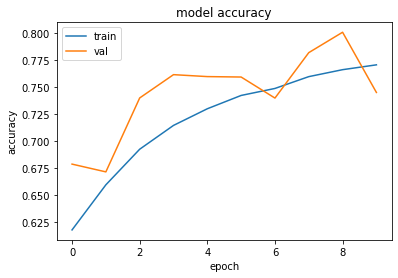

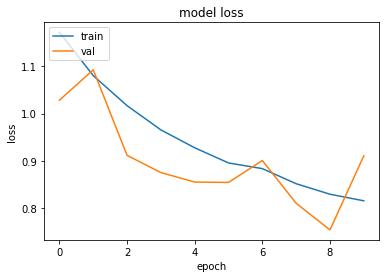

In [ ]:
plot_history(history3)

 > What are the conclusions? Does the performance improve? (1-2 paragraphs)

 


Yes, the performance has showed some even better results. Training for the same number of epochs and taking Adam and RMSProp optimizers we come up with accuracies above 80% in the validation set and above 77% in the test set.

We might hope that training for more epochs the results will be improved.

### 6. Transfer Learning
(1 point) Apply the transfer-learning technique using any of the pre-trained models available in Keras as a base (see: https://www.tensorflow.org/api_docs/python/tf/keras/applications).

The approach implementation is showed as follows.

In [ ]:
def cnn_transfer_learning_model(input_shape, n_classes, activation_function):
    base_model = tf.keras.applications.ResNet50(
        include_top=False, #not using their FC layer
        weights="imagenet", 
        input_shape=input_shape+(3,)
    ) 
    base_model.trainable = False
    n_layers = len(base_model.layers)
    for i in range(n_layers-10, n_layers):
      base_model.layers[i].trainable = True

    input = keras.Input(shape=input_shape+(3,))
    x = layers.Resizing(32, 32, interpolation="bilinear")(input)
    x = layers.Rescaling(1.0/255)(x)
    x = base_model(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.00005))(x)  #128 neurons
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.00005))(x)  #128 neurons
    x = layers.Dropout(0.5)(x) #50% dropout
    output = layers.Dense(
        n_classes, 
        activation=activation_function, 
        kernel_regularizer=keras.regularizers.l2(0.01)
    )(x)

    return keras.Model(input, output)

In [ ]:
model4 = cnn_transfer_learning_model(
    input_shape=(32,32), n_classes=9, activation_function="softmax"
)
model4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resizing_4 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dense_9 (Dense)             (None, 128)               3289

In [ ]:
epochs = 10
callbacks = [
             keras.callbacks.ModelCheckpoint(
                  'model4.h5', 
                  monitor='val_loss', 
                  save_best_only=True
             ),
             keras.callbacks.EarlyStopping(
                  monitor="val_loss",
                  min_delta=0.001,
                  patience=10
             )
]

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = "categorical_crossentropy" 
model4.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=[
            "accuracy", 
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
    ],
)

In [ ]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                      layers.RandomTranslation(0.4,0.4),
                                      layers.RandomRotation(0.1)])

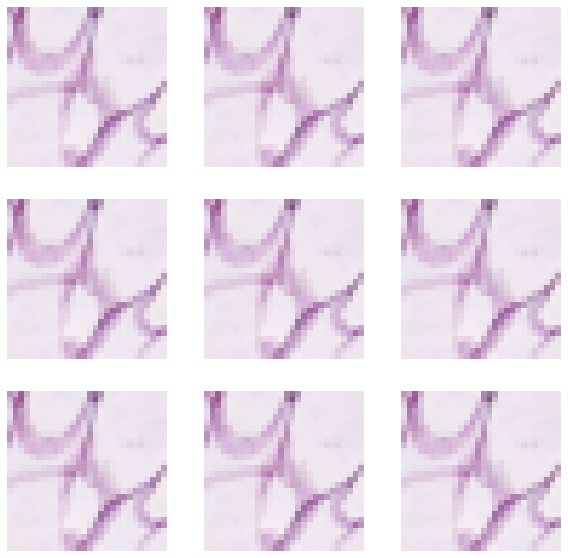

In [ ]:
plt.figure(figsize=(10, 10))
test_images, test_labels = train_data_cnn[0]
for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
start_time = time.time()

history4 = model4.fit(
    train_data_cnn, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_data_cnn,
)

end_time = time.time()
print(f"Training took {end_time - start_time} seconds.")

Epoch 1/10
2812/2812 [==============================] - 182s 64ms/step - loss: 2.2167 - accuracy: 0.1432 - precision_4: 0.1422 - recall_4: 3.6673e-04 - val_loss: 2.1490 - val_accuracy: 0.1573 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/10
2812/2812 [==============================] - 179s 64ms/step - loss: 2.1440 - accuracy: 0.1657 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.1116 - val_accuracy: 0.1671 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/10
2812/2812 [==============================] - 178s 63ms/step - loss: 2.1249 - accuracy: 0.1844 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.0877 - val_accuracy: 0.2053 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 4/10
2812/2812 [==============================] - 176s 63ms/step - loss: 2.1139 - accuracy: 0.1932 - precision_4: 0.2727 - recall_4: 3.3339e-05 - val_loss: 2.0758 - val_accuracy: 0.2252 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e

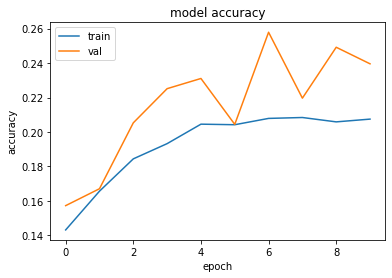

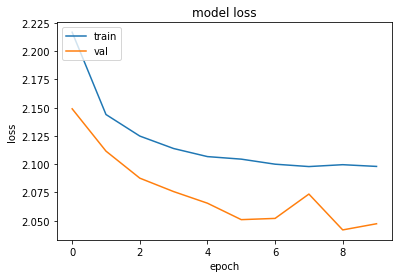

In [ ]:
plot_history(history4)

In [ ]:
results4 = model4.evaluate(test_data_cnn, batch_size=32)

224/224 [==============================] - 4s 19ms/step - loss: 3.7981 - accuracy: 0.4286 - precision: 0.4551 - recall: 0.4173


> What are the conclusions? Does the performance improve? (1-2 paragraphs)

The Transfer Learning approach didn't work very well, even tough we've tried to improve it by adding two dense layers with relu activations, followed by a drop out of 50% at the end. We only achieved 42.9% of accuracy in the test dataset, which is now our worst result.

### 7. Conclusions
(1 point) Pick **your best model** and plot the confusion matrix in the **test set**. 


> What are the conclusions? (1-2 paragraphs)


For the purpose of this task, we saw that the CNN we built in item 5, adapted with the Adam and RMSProp optimizers, provided the best results among all the models. We even tried to get some success with pre-trained models using Transfer Learning, but that wasn't very effective.

Talking about the whole work in general, it was very interesting to explore different techniques for classifying images and being able to observe the limitations of each one in practice. We have seen that by adopting more complex models that offer non-linear decision boundaries, the results tend to increase significantly.

However, due to the large number of activities we were not able to focus that much on each one, otherwise we would run out of time. Perhaps if we had fewer models to explore, we would be able to focus more efforts on improving the results we obtained.

Anyways, we are already quite pleased with the opportunity to explore in practice such different techniques of image classification, since our final project proposal for this discipline is also in the same scope of this task. We finish this task with the certainty that it will help us with that challenge.